In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools


In [ ]:
!file /content/Breast+Cancer+Dataset+Small+-partial-.zip
!ls -lh /content/Breast+Cancer+Dataset+Small+-partial-.zip


/content/Breast+Cancer+Dataset+Small+-partial-.zip: Zip archive data, at least v2.0 to extract, compression method=deflate
-rw-r--r-- 1 root root 126M Jun  7 00:03 /content/Breast+Cancer+Dataset+Small+-partial-.zip


In [ ]:
import os

old_path = '/content/Breast+Cancer+Dataset+Small+-partial-.zip'
new_path = '/content/breast_cancer_dataset.zip'
os.rename(old_path, new_path)


In [ ]:
import os
import zipfile

# renaming to avoid special character issues
old_path = '/content/Breast+Cancer+Dataset+Small+-partial-.zip'
new_path = '/content/breast_cancer_dataset.zip'

if not os.path.exists(new_path):
    os.rename(old_path, new_path)

# defining extraction folder
extract_path = '/content/breast-cancer-dataset'

# extracting
if not os.path.exists(extract_path):
    with zipfile.ZipFile(new_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Confirming extraction
print(f'Files in {extract_path}:')
print(os.listdir(extract_path))


Files in /content/breast-cancer-dataset:
['malign', 'benign']


In [ ]:
# Loading the  images
benign = np.array(Dataset_loader('/content/breast-cancer-dataset/benign', 224))
malign = np.array(Dataset_loader('/content/breast-cancer-dataset/malign', 224))




100%|██████████| 127/127 [00:02<00:00, 62.33it/s]


In [ ]:
# Creating our independent and dependent features:
benign_label = np.zeros(len(benign))
malign_label = np.ones(len(malign))

In [ ]:
# Combine benign and malign image arrays into one feature set (X)
X = np.concatenate((benign, malign), axis=0)

# Combine benign and malign labels into one label array (Y)
Y = np.concatenate((benign_label, malign_label), axis=0)


In [ ]:
# Shuffling the dataset to randomize the order of benign and malignant samples after concatenation
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]

# One-hot encoding the shuffled labels into 2 classes (benign, malignant)
Y = to_categorical(Y, num_classes=2)


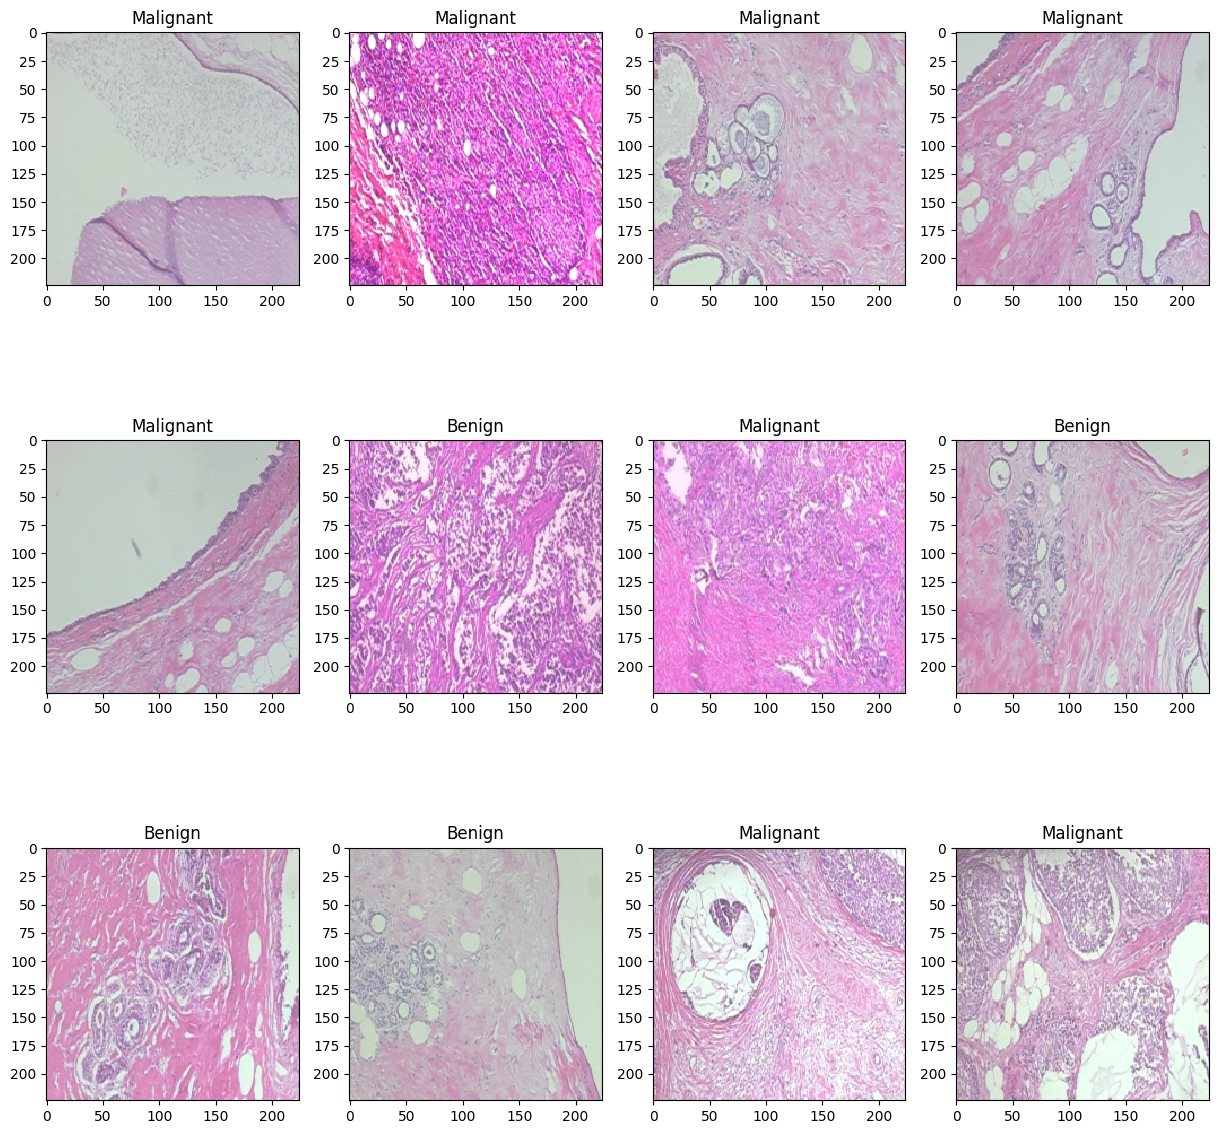

In [ ]:
# Split the dataset into training and validation sets with 20% of data for validation
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Set figure size for plotting sample images
w = 60
h = 40
fig = plt.figure(figsize=(15, 15))

# Define the number of columns and rows for the subplot grid
columns = 4
rows = 3

# Loop through a subset of the training images to visualize samples
for i in range(1, columns * rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    # Set the subplot title based on the label of the image
    if np.argmax(Y[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    # Display the image
    plt.imshow(x_train[i], interpolation='nearest')

# Render the plotted images
plt.show()


In [ ]:
# Image preprocessing part
# Define batch size for training iterations
BATCH_SIZE = 16

# Initialize image data generator with real-time data augmentation
train_generator = ImageDataGenerator(
    zoom_range=2,          # Apply random zoom within range [1/2, 2] to simulate scale variations
    rotation_range=90,     # Randomly rotate images up to 90 degrees to increase rotational invariance
    horizontal_flip=True,  # Randomly flip images horizontally to augment dataset diversity
    vertical_flip=True,    # Randomly flip images vertically to augment dataset diversity
)


In [26]:
def build_model(backbone, lr=1e-3):
    # Initialize a sequential model container
    model = Sequential()

    # Add the pre-trained backbone model (feature extractor)
    model.add(backbone)

    # Add global average pooling to reduce spatial dimensions to a single vector per feature map
    model.add(layers.GlobalAveragePooling2D())

    # Add dropout layer with 50% dropout rate to reduce overfitting
    model.add(layers.Dropout(0.5))

    # Add batch normalization to stabilize and speed up training
    model.add(layers.BatchNormalization())

    # Add final dense layer with 2 units for 2 classes and softmax activation for classification probabilities
    model.add(layers.Dense(2, activation='softmax'))

    # Compile the model with binary crossentropy loss, Adam optimizer, and accuracy metric
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),  # Correct argument name
        metrics=['accuracy']
    )

    # Return the compiled model ready for training
    return model


In [ ]:

# Load DenseNet201 pretrained on ImageNet without the top classification layers, specifying input shape
# Build the full model using the pretrained DenseNet201 backbone with a specified learning rate
# Print the architecture summary of the constructed model including layers, shapes, and parameters
resnet = DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))
model = build_model(resnet, lr=1e-4)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         3,842 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,333,506 (69.94 MB)

 Trainable params: 18,100,610 (69.05 MB)

 Non-trainable params: 232,896 (909.75 KB)

In [32]:
# Learning rate scheduler callback: monitors validation accuracy ('val_accuracy') during training
# If validation accuracy does not improve for 5 consecutive epochs ('patience=5'), it reduces the learning rate by multiplying it by 0.2 ('factor=0.2')
# This reduction helps the model fine-tune its weights more carefully to improve performance and avoid getting stuck in local minima
# 'min_lr=1e-7' sets a lower bound on how small the learning rate can get to prevent it from becoming too small
# 'verbose=1' enables printing a message whenever the learning rate is reduced
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1, factor=0.2, min_lr=1e-7)

import math  # Make sure math is imported for ceil function

# Calculate steps per epoch using ceiling to ensure all samples are included
steps_per_epoch = math.ceil(x_train.shape[0] / BATCH_SIZE)

# Train the model using augmented data from train_generator on training set (x_train, y_train)
# Use specified batch size and number of epochs (7)
# Validate model performance on (x_val, y_val) after each epoch
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=steps_per_epoch,  # Use ceil to avoid data shortage warning
    epochs=7,
    validation_data=(x_val, y_val),
    callbacks=[learn_control]
)


Epoch 1/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 248s 21s/step - accuracy: 0.8844 - loss: 0.2639 - val_accuracy: 0.6458 - val_loss: 0.5154 - learning_rate: 1.0000e-04
Epoch 2/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 246s 19s/step - accuracy: 0.9248 - loss: 0.2147 - val_accuracy: 0.6042 - val_loss: 0.6659 - learning_rate: 1.0000e-04
Epoch 3/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 276s 21s/step - accuracy: 0.9294 - loss: 0.2083 - val_accuracy: 0.6042 - val_loss: 0.7497 - learning_rate: 1.0000e-04
Epoch 4/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 244s 20s/step - accuracy: 0.9309 - loss: 0.1892 - val_accuracy: 0.6042 - val_loss: 0.7387 - learning_rate: 1.0000e-04
Epoch 5/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 244s 20s/step - accuracy: 0.9206 - loss: 0.1586 - val_accuracy: 0.6042 - val_loss: 0.8264 - learning_rate: 1.0000e-04
Epoch 6/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9261 - loss: 0.1522 
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
12/12 ━━━━━━━━━━━━━━━━━━━━ 263s 21s/step - accuracy: 0.9274 - lo

<Axes: >

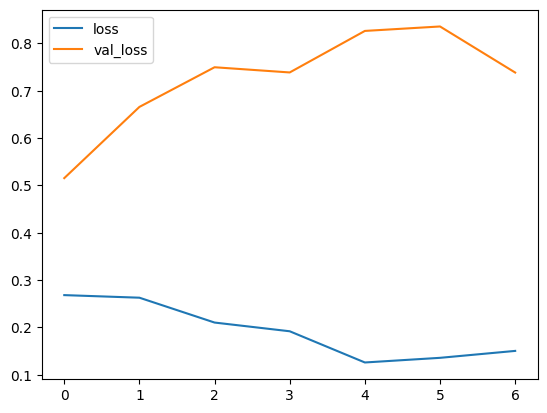

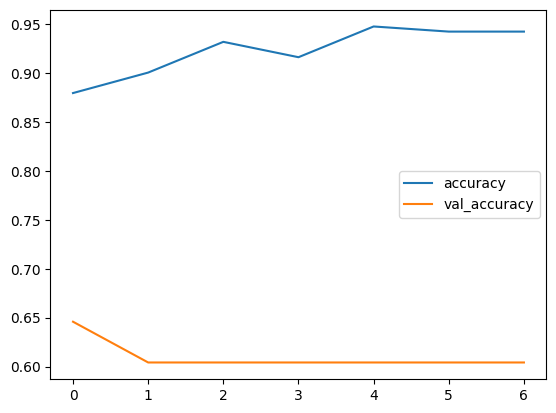

In [33]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [35]:
import os
import pickle

# Define the save path
save_dir = 'drive/MyDrive/Dataset/DataScience-Pianalytix-Models'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the generator and model
pickle.dump(train_generator, open(os.path.join(save_dir, 'image-generator-model.pkl'), 'wb'))
model.save(os.path.join(save_dir, 'breast-cancer-model.h5'))
